In [ ]:
!unzip flowers.zip

Archive:  flowers.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.jpg  
  inflating: fl

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

In [ ]:
# Указываем путь к папке с данными
data_dir = "flowers"

# Указываем путь для разделенных данных
base_dir = "split_flowers"
os.makedirs(base_dir, exist_ok=True)

# Создаем папки для train, validation и test
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

for split in [train_dir, val_dir, test_dir]:
    os.makedirs(split, exist_ok=True)

In [ ]:
# Перемещение данных
for category in os.listdir(data_dir):
    category_path = os.path.join(data_dir, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        train, test = train_test_split(images, test_size=0.3, random_state=42)
        val, test = train_test_split(test, test_size=0.5, random_state=42)

        for split, split_dir in zip([train, val, test], [train_dir, val_dir, test_dir]):
            category_split_dir = os.path.join(split_dir, category)
            os.makedirs(category_split_dir, exist_ok=True)

            for image in split:
                src = os.path.join(category_path, image)
                dst = os.path.join(category_split_dir, image)
                shutil.copy(src, dst)

In [ ]:
# Генераторы данных с аугментацией для обучающего набора
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Создаем генераторы данных
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3019 images belonging to 5 classes.
Found 649 images belonging to 5 classes.
Found 649 images belonging to 5 classes.


In [ ]:
# Загружаем предобученную MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Замораживаем веса базовой модели

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Добавляем собственные слои
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Сглаживаем выходы
    layers.Dense(128, activation='relu'),  # Полносвязный слой
    layers.Dropout(0.5),  # Dropout для предотвращения переобучения
    layers.Dense(5, activation='softmax')  # Выходной слой (5 классов)
])

# Компилируем модель
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25
)

Epoch 1/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 42s 419ms/step - accuracy: 0.8751 - loss: 0.3234 - val_accuracy: 0.9014 - val_loss: 0.3200
Epoch 2/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 39s 387ms/step - accuracy: 0.8945 - loss: 0.2992 - val_accuracy: 0.9076 - val_loss: 0.2990
Epoch 3/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 39s 389ms/step - accuracy: 0.8993 - loss: 0.2849 - val_accuracy: 0.9045 - val_loss: 0.3366
Epoch 4/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 40s 398ms/step - accuracy: 0.9018 - loss: 0.2920 - val_accuracy: 0.9122 - val_loss: 0.3113
Epoch 5/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 39s 390ms/step - accuracy: 0.9022 - loss: 0.2646 - val_accuracy: 0.9029 - val_loss: 0.3214
Epoch 6/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 41s 377ms/step - accuracy: 0.8972 - loss: 0.2735 - val_accuracy: 0.9060 - val_loss: 0.2930
Epoch 7/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 40s 379ms/step - accuracy: 0.8945 - loss: 0.2626 - val_accuracy: 0.9076 - val_loss: 0.2918
Epoch 8/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 41s 385ms/step - accuracy: 0.8999 - loss: 0.2553 - val_accu

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Точность на тестовом наборе: {test_acc:.2f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8950 - loss: 0.4202
Точность на тестовом наборе: 0.89


In [ ]:
model.save("flower_classifier.h5")

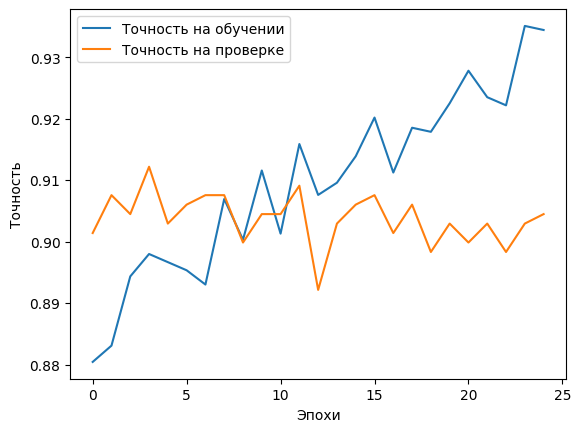

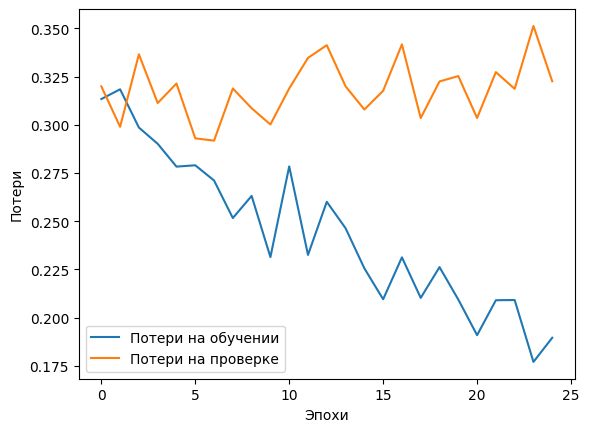

In [ ]:
# Графики точности
plt.plot(history.history['accuracy'], label='Точность на обучении')
plt.plot(history.history['val_accuracy'], label='Точность на проверке')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()

# Графики функции потерь
plt.plot(history.history['loss'], label='Потери на обучении')
plt.plot(history.history['val_loss'], label='Потери на проверке')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

In [10]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Загружаем модель
model = load_model("flower_classifier.h5")

# Задаём имена классов вручную
class_names = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

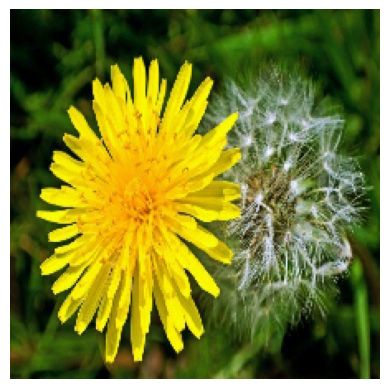

In [19]:
# Указываем путь к изображению
image_path = "/content/dandelion.jpg"

# Загружаем и подготавливаем изображение
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)  # Преобразуем в массив
img_array = np.expand_dims(img_array, axis=0)  # Добавляем ось для батча
img_array = img_array / 255.0  # Нормализация

# Визуализируем изображение
plt.imshow(img)
plt.axis("off")
plt.show()

In [20]:
# Делаем предсказание
predictions = model.predict(img_array)

# Определяем индекс и класс с максимальной вероятностью
predicted_index = np.argmax(predictions)  # Индекс с максимальной вероятностью
predicted_class = class_names[predicted_index]  # Соответствующий класс
confidence = np.max(predictions)  # Уверенность модели

print(f"Предсказанный класс: {predicted_class}")
print(f"Уверенность модели: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Предсказанный класс: dandelion
Уверенность модели: 1.00
